## 0. Preprocess: load data and shuffle it for reliable performance

In [1]:
# load data and shuffle it for stable performance
from load import load_data

x, y = load_data(rsize=128)

print(x.shape)
print(y.shape)

num_classes = 4

(478, 128, 128, 3)
(478,)


## 1. LocallConnectedNet
### the structure of the locally connected network
======locally connected layers======  
----(F, C, H, W)----S-next---params  
L1: (16, 3, 11, 11) 3 40,   9318400  
L2: (16, 16, 9, 9)  1 32,   21250048  
L3: (16, 16, 9, 9)  1 24,   11953152  
======fully connected layers========  
F1: (24*24*16, 300)  
F2: (300, 300)  
F3: (300, 300)  
======output layer==================  
F:  (300, 4)
softmax


In [2]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import LocallyConnected2D, BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import LeakyReLU, Dense, Dropout, Flatten, Softmax
from keras import regularizers
from keras.utils import to_categorical
# kernel_regularizer=regularizers.l2(0.001)

def LocallyConnectedNet():
    model = Sequential()

   # N, 3 ,128, 128
    model.add(BatchNormalization(axis=1, input_shape=(128, 128, 3)))
    model.add(LeakyReLU(alpha=0.05))
    model.add(LocallyConnected2D(16, 11, strides=(3, 3)))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))

    # N, 16, 40, 40
    model.add(LocallyConnected2D(16, 9))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))

    # N, 16, 32, 32
    model.add(LocallyConnected2D(16, 9))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))
    
    # N, 16, 24, 24
    model.add(Flatten())
    
    # N, 16*24*24
    model.add(Dense(300))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.5))

    model.add(Dense(300))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.5))

    model.add(Dense(300))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Softmax())
    
    return model

Using TensorFlow backend.


### sanity check
overfitting on a small subset of training data to verify the sanity of the architecture

In [3]:
# overfitting on small set of data
import matplotlib.pyplot as plt

x_pre, y_pre = x[:30], y[:30]
y_pre = to_categorical(y_pre, num_classes)

model = LocallyConnectedNet()
optim = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
hist = model.fit(x_pre, y_pre, batch_size=15, epochs=20, shuffle=True)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
30/30 [==============================] - 141s 5s/step - loss: 1.6142 - acc: 0.4333
Epoch 2/20
30/30 [==============================] - 36s 1s/step - loss: 1.2323 - acc: 0.5667
Epoch 3/20
30/30 [==============================] - 29s 958ms/step - loss: 0.5743 - acc: 0.8000
Epoch 4/20
30/30 [==============================] - 35s 1s/step - loss: 0.4353 - acc: 0.9000
Epoch 5/20
30/30 [==============================] - 31s 1s/step - loss: 0.1315 - acc: 1.0000
Epoch 6/20
30/30 [==============================] - 30s 1s/step - loss: 0.0948 - acc: 1.0000
Epoch 7/20
30/30 [==============================] - 32s 1s/step - loss: 0.1003 - acc: 1.0000
Epoch 8/20
30/30 [==============================] - 30s 1s/step - loss: 0.0669 - acc: 1.0000
Epoch 9/20
30/30 

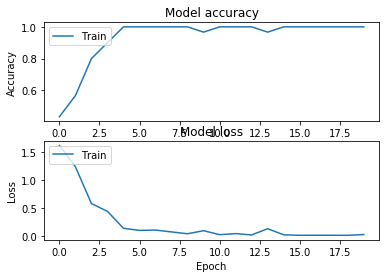

In [4]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(hist.history['acc'])
#plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### cross validate the loss and accuracy of LocallConnectedNet
Since the training dataset is very small, we use 4-fold cross validation to evaluate loss and accuracy of the model.

In [5]:
import numpy as np

# split for cross validation
delim = [120, 240, 360]
xs = np.split(x, delim)
ys = np.split(y, delim)

# validation
loss, acc = 0, 0
for vali in range(num_classes):
    print("====== Cross validation step %d ======"%(vali+1))
    x_train = np.vstack([xs[i] for i in range(num_classes) if i != vali])
    x_val = xs[vali]
    y_train = to_categorical(np.hstack([ys[i] for i in range(num_classes) if i != vali]), num_classes)
    y_val = to_categorical(ys[vali], num_classes)
    
    # establish model
    model = LocallyConnectedNet()
    
    optim = optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=16, epochs=20, shuffle=True)
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    loss += hist.history['val_acc'][-1]
    acc += hist.history['val_loss'][-1]

print("average loss: %f"%(loss/num_classes))
print("average accuracy: %f"%(acc/num_classes))

====== Cross validation step 1 ======
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 358 samples, validate on 120 samples
Epoch 1/20
358/358 [==============================] - 529s 1s/step - loss: 1.7030 - acc: 0.3128 - val_loss: 4.6163 - val_acc: 0.3000
Epoch 2/20
358/358 [==============================] - 388s 1s/step - loss: 1.3079 - acc: 0.4693 - val_loss: 2.6090 - val_acc: 0.2083
Epoch 3/20
358/358 [==============================] - 385s 1s/step - loss: 1.0855 - acc: 0.5419 - val_loss: 1.9848 - val_acc: 0.3250
Epoch 4/20
358/358 [==============================] - 382s 1s/step - loss: 0.6716 - acc: 0.7291 - val_loss: 2.1937 - val_acc: 0.3083
Epoch 5/20
358/358 [==============================] - 386s 1s/step - loss: 0.2840 - acc: 0.9106 - val_loss: 3.3964 - val_acc: 0.3000
Epoch 6/20
358/3

NameError: name 'plt' is not defined

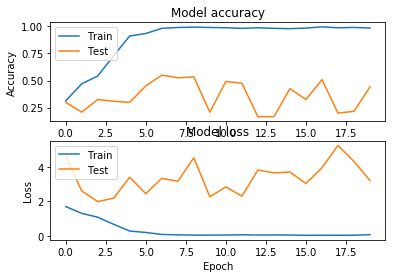

In [8]:
import matplotlib.pylab as plt

plt.figure()
plt.subplot(2,1,1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 2. VanillaNeuralNet
VanillaNeuralNet is an instance of fully connected neural network, and the definition of its structure is as follows:

In [16]:
def VanillaNeuralNet():
    model = Sequential()
    
    model.add(Flatten())
    
    model.add(BatchNormalization(axis=1, input_shape=(128*128*3,)))
    model.add(LeakyReLU(0.05))
    
    model.add(Dense(1024))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(0.05))
    model.add(Dropout(0.5))
    
    model.add(Dense(1024))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(0.05))
    model.add(Dropout(0.5))
    
    model.add(Dense(1024))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(0.05))
    model.add(Dropout(0.05))
    
    model.add(Dense(1024))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(0.05))
    model.add(Dropout(0.5))
    
    model.add(Dense(512))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(0.05))
    model.add(Dropout(0.05))
    
    model.add(Dense(128))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(0.05))
    model.add(Dropout(0.05))
    
    model.add(Dense(num_classes))
    model.add(Softmax())
    
    return model

### Sanity check
overfitting on the same subset of training data for the sanity check of VanillaNeuralNet

Epoch 1/20
30/30 [==============================] - 32s 1s/step - loss: 1.3943 - acc: 0.2333
Epoch 2/20
30/30 [==============================] - 2s 69ms/step - loss: 0.7214 - acc: 0.7667
Epoch 3/20
30/30 [==============================] - 2s 66ms/step - loss: 0.3406 - acc: 0.9667
Epoch 4/20
30/30 [==============================] - 2s 63ms/step - loss: 0.1835 - acc: 1.0000
Epoch 5/20
30/30 [==============================] - 2s 71ms/step - loss: 0.1511 - acc: 1.0000
Epoch 6/20
30/30 [==============================] - 2s 65ms/step - loss: 0.0596 - acc: 1.0000
Epoch 7/20
30/30 [==============================] - 2s 60ms/step - loss: 0.1045 - acc: 0.9667
Epoch 8/20
30/30 [==============================] - 2s 61ms/step - loss: 0.0522 - acc: 1.0000
Epoch 9/20
30/30 [==============================] - 2s 68ms/step - loss: 0.0314 - acc: 1.0000
Epoch 10/20
30/30 [==============================] - 2s 63ms/step - loss: 0.0270 - acc: 1.0000
Epoch 11/20
30/30 [==============================] - 2s 63ms

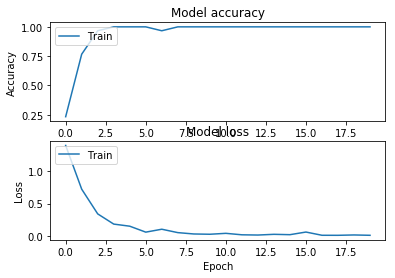

In [17]:
model = VanillaNeuralNet()
optim = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
hist = model.fit(x_pre, y_pre, batch_size=15, epochs=20, shuffle=True)

plt.figure()
plt.subplot(2,1,1)
plt.plot(hist.history['acc'])
#plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### Training
For the sake of efficiency, we just split the dataset into 2 parts instead of cross validation. First part is training data, which holds pixels of 360 images, while the validation set has 118 images.  
We will do the same in the training cell for the following comparation.

Train on 360 samples, validate on 118 samples
Epoch 1/20
360/360 [==============================] - 52s 145ms/step - loss: 1.1183 - acc: 0.5528 - val_loss: 4.7588 - val_acc: 0.1610
Epoch 2/20
360/360 [==============================] - 22s 60ms/step - loss: 0.5164 - acc: 0.8028 - val_loss: 4.6776 - val_acc: 0.0847
Epoch 3/20
360/360 [==============================] - 21s 59ms/step - loss: 0.3492 - acc: 0.8750 - val_loss: 7.0111 - val_acc: 0.2542
Epoch 4/20
360/360 [==============================] - 21s 59ms/step - loss: 0.2135 - acc: 0.9194 - val_loss: 6.9737 - val_acc: 0.0763
Epoch 5/20
360/360 [==============================] - 21s 59ms/step - loss: 0.2787 - acc: 0.9056 - val_loss: 5.8663 - val_acc: 0.2542
Epoch 6/20
360/360 [==============================] - 21s 59ms/step - loss: 0.1750 - acc: 0.9389 - val_loss: 6.7501 - val_acc: 0.2542
Epoch 7/20
360/360 [==============================] - 21s 58ms/step - loss: 0.1297 - acc: 0.9667 - val_loss: 6.1960 - val_acc: 0.0508
Epoch 8/20
360/

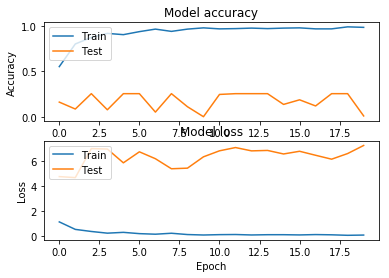

In [18]:
delim = [360]
xs = np.split(x, delim)
ys = np.split(y, delim)

x_train, x_val = xs[0], xs[1]
y_train, y_val = to_categorical(ys[0], num_classes), to_categorical(ys[1], num_classes)

model = VanillaNeuralNet()
optim = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=64, epochs=20, shuffle=True)

plt.figure()
plt.subplot(2,1,1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 3. Neural network with feature engineering
Instead of training on raw pixels of data, we resort to some fueature engineering methods which could theoretically improve the performance of vanilla neural network.

In [ ]:
def FENet():
    

## 4. ConvNet
ConvNet is an instance of typical convolutional neural network.

In [11]:
def ConvNet():
    model = Sequential()
    
    model.add(BatchNormalization(axis=1, input_shape=(128, 128, 3)))
    model.add(LeakyReLU(0.05))
    # 3, 128, 128
    model.add(Conv2D(128, 5, padding='same'))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(0.05))
    model.add(MaxPooling2D())
    # 64, 64, 64
    model.add(Conv2D(128, 3, padding='same'))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(0.05))
    
    model.add(Conv2D(64, 3, padding='same'))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(0.05))
    model.add(MaxPooling2D())
    # 64, 32, 32
    model.add(Conv2D(64, 3, padding='same'))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(0.05))
    
    model.add(Flatten())
    
    model.add(Dense(300))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(0.05))
    model.add(Dropout(0.5))
    
    model.add(Dense(300))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(0.05))
    model.add(Dropout(0.5))
    
    model.add(Dense(300))
    model.add(BatchNormalization(axis=1))
    model.add(LeakyReLU(0.05))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Softmax())
    
    return model

### Sanity check

Epoch 1/20
30/30 [==============================] - 27s 914ms/step - loss: 2.1274 - acc: 0.2667
Epoch 2/20
30/30 [==============================] - 10s 335ms/step - loss: 1.5464 - acc: 0.3667
Epoch 3/20
30/30 [==============================] - 6s 216ms/step - loss: 1.6172 - acc: 0.4000
Epoch 4/20
30/30 [==============================] - 7s 228ms/step - loss: 1.1093 - acc: 0.5667
Epoch 5/20
30/30 [==============================] - 6s 209ms/step - loss: 0.9607 - acc: 0.7000
Epoch 6/20
30/30 [==============================] - 6s 208ms/step - loss: 0.8062 - acc: 0.7000
Epoch 7/20
30/30 [==============================] - 7s 218ms/step - loss: 0.5093 - acc: 0.8333
Epoch 8/20
30/30 [==============================] - 6s 212ms/step - loss: 0.4372 - acc: 0.9000
Epoch 9/20
30/30 [==============================] - 6s 212ms/step - loss: 0.2197 - acc: 0.9333
Epoch 10/20
30/30 [==============================] - 6s 209ms/step - loss: 0.1496 - acc: 1.0000
Epoch 11/20
30/30 [============================

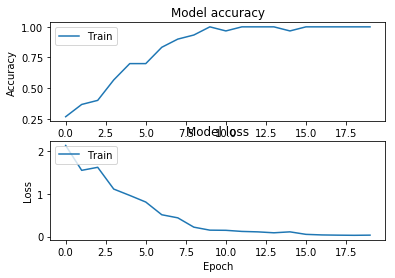

In [12]:
model = ConvNet()
optim = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
hist = model.fit(x_pre, y_pre, batch_size=64, epochs=20, shuffle=True)

plt.figure()
plt.subplot(2,1,1)
plt.plot(hist.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### Training

In [ ]:
delim = [360]
xs = np.split(x, delim)
ys = np.split(y, delim)

x_train, x_val = xs[0], xs[1]
y_train, y_val = to_categorical(ys[0], num_classes), to_categorical(ys[1], num_classes)

model = ConvNet()
optim = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=64, epochs=20, shuffle=True)

plt.figure()
plt.subplot(2,1,1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Train on 360 samples, validate on 118 samples
Epoch 1/20
360/360 [==============================] - 494s 1s/step - loss: 1.3347 - acc: 0.4917 - val_loss: 6.2761 - val_acc: 0.0000e+00
Epoch 2/20
360/360 [==============================] - 543s 2s/step - loss: 0.6037 - acc: 0.7861 - val_loss: 4.6154 - val_acc: 0.2712
Epoch 3/20
360/360 [==============================] - 576s 2s/step - loss: 0.3021 - acc: 0.9361 - val_loss: 5.0325 - val_acc: 0.2712
Epoch 4/20
360/360 [==============================] - 578s 2s/step - loss: 0.1650 - acc: 0.9583 - val_loss: 5.0574 - val_acc: 0.0678
Epoch 5/20
360/360 [==============================] - 501s 1s/step - loss: 0.0826 - acc: 0.9806 - val_loss: 5.8440 - val_acc: 0.0508
Epoch 6/20
360/360 [==============================] - 534s 1s/step - loss: 0.0423 - acc: 0.9944 - val_loss: 6.8455 - val_acc: 0.0000e+00
Epoch 7/20
 64/360 [====>.........................] - ETA: 7:05 - loss: 0.0112 - acc: 1.0000